In [1]:
import os
import sys
root=os.path.abspath(os.path.join(r"D:\project_meta\NNproject\NNI\notebook\NNITest_0231104.ipynb","../.."))
print(root)
sys.path.append(root)
os.environ["TORCH_HOME"]=r"E:\Data\torch-model"
import warnings  
warnings.filterwarnings("ignore", category=RuntimeWarning, module="mne")


D:\project_meta\NNproject\NNI


In [2]:
import torch
import pandas as pd
from project.dataprocess import FolderTree
from project.dataset.SelfDataset import TableControlFullLoadDataset
from torch.utils.data import DataLoader, Subset, SubsetRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [3]:
data_root=r'D:\dataset\driver_dataset\DROZY\DROZY'
output_root=r"D:\project_meta\NNproject\NNI\output"
data_path_dict=FolderTree.getDataPath(data_root=data_root)
output_path_dic=FolderTree.getOutPath(output_root=output_root)


In [4]:
info_table=pd.read_csv(output_path_dic["info_file"])
train_data_table,test_data_table=train_test_split(info_table,test_size=0.2,shuffle=False)

train_dataset=TableControlFullLoadDataset(train_data_table,data_root=data_root,output_root=output_root,Mintime=15)
train_dataloader=DataLoader(train_dataset,batch_size=64)

test_dataset=TableControlFullLoadDataset(test_data_table,data_root=data_root,output_root=output_root)
test_dataloader=DataLoader(test_dataset,batch_size=512)

In [5]:
from project.model.CNN1D import simple_cnn1d
cnn=simple_cnn1d(input_channels=5,num_classes=4,list_down=[16,32,64,64,64])
from torchsummary import summary
summary(cnn,(5,3*2560),batch_size=3,device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [3, 16, 7680]             576
       BatchNorm1d-2              [3, 16, 7680]              32
              ReLU-3              [3, 16, 7680]               0
         MaxPool1d-4              [3, 16, 3839]               0
            Conv1d-5              [3, 32, 1920]           1,568
       BatchNorm1d-6              [3, 32, 1920]              64
              ReLU-7              [3, 32, 1920]               0
            Conv1d-8               [3, 64, 960]           6,208
       BatchNorm1d-9               [3, 64, 960]             128
             ReLU-10               [3, 64, 960]               0
           Conv1d-11               [3, 64, 480]          12,352
      BatchNorm1d-12               [3, 64, 480]             128
             ReLU-13               [3, 64, 480]               0
           Conv1d-14               [3, 

In [6]:
import torch
from d2l import torch as d2l
import torch.nn.functional as F
import datetime
import sklearn as sk
from sklearn.metrics import precision_score, recall_score, f1_score
device=torch.device("cuda")
device
net=simple_cnn1d(input_channels=5,num_classes=4,list_down=[16,32,64,64,64])
net.to(device)

optim=torch.optim.SGD(net.parameters(),lr=0.01,weight_decay=5e-4)
loss=torch.nn.CrossEntropyLoss().to(device="cuda")
num_epochs=2000
   

timer, num_batches = d2l.Timer(), len(train_dataloader)
best_train_acc=0
best_train_loss=0

best_test_acc=0

stagnate_times=0

current_time = datetime.datetime.now()
formatted_time = current_time.strftime("%Y_%m_%d_%H_%M_%S")
parameterFolder=os.path.join(r"D:\project_meta\NNproject\NNI\output\model_parameter\FilterSignalCNN1D",f"{formatted_time}")
print(parameterFolder)
os.makedirs(parameterFolder)



D:\project_meta\NNproject\NNI\output\model_parameter\FilterSignalCNN1D\2023_11_06_20_20_22


KeyboardInterrupt: 

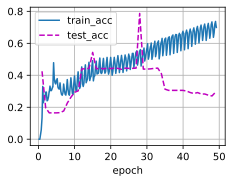

In [7]:
animator = d2l.Animator(xlabel='epoch',
                        legend=['train_acc','test_acc'])

for epoch in range(num_epochs):
    metric_train = d2l.Accumulator(3)
    net.train()
    for i,data_dict in enumerate(train_dataloader):
        optim.zero_grad()
        x=data_dict["data"].to(torch.float32).to(device)     
        y=data_dict["LEVEL"].long().to(device)
        y_hat=net(x)
        l=F.cross_entropy(y_hat, y)
        l.mean().backward()
        optim.step()     
        pre=torch.argmax(y_hat.detach().cpu(),dim=1)
        num_true=sum(pre==y.cpu())
        metric_train.add(num_true,y.numel())
        if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
            animator.add(epoch + (i + 1) / num_batches, (metric_train[0]/metric_train[1],None))



    net.eval()
    metric_test = d2l.Accumulator(2)
    for data_dict in test_dataloader:
        x=data_dict["data"].to(torch.float32).to(device)
        y=data_dict["LEVEL"].long().to(device)
        y_hat=net(x)
        pre=torch.argmax(y_hat.detach().cpu(),dim=1)
        num_true=sum(pre==y.cpu())
        metric_test.add(num_true,y.numel())
    animator.add(epoch+ 1, (None,metric_test[0]/metric_test[1]))
    
    if best_test_acc<(metric_test[0]/metric_test[1]):
        best_test_acc=metric_test[0]/metric_test[1]
        stagnate_times=0
        
        
        torch.save(net.state_dict(),os.path.join(parameterFolder,f'LEVEL{best_test_acc}.pt'))
    else:
        stagnate_times=stagnate_times+1
    
    # if stagnate_times>50:
    #     break

<Axes: >

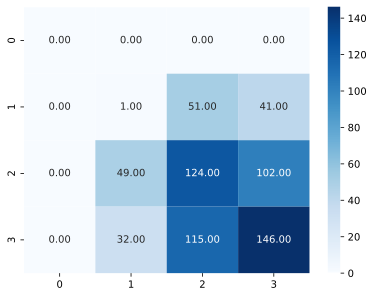

In [9]:
from sklearn.metrics import confusion_matrix
import numpy as np
num_classes=4
net=simple_cnn1d(input_channels=5,num_classes=10,list_down=[16,32,64,64,64])
net.to(device)
confusion_matrix_test = np.zeros((num_classes, num_classes))
net.load_state_dict(torch.load(r"D:\project_meta\NNproject\NNI\output\model_parameter\FilterSignalCNN1D\2023_11_06_20_20_22\LEVEL0.7866868381240545.pt"))
for data_dict in test_dataloader:
    x=data_dict["data"].to(torch.float32).to(device)
    y=data_dict["LEVEL"].long().to(device)
    y_hat=net(x)
    pre=torch.argmax(y_hat.detach().cpu(),dim=1)
    num_true=sum(pre==y.cpu())
    y_pred = torch.stack((pre, y.cpu()), dim=1)
    confusion_matrix_test += confusion_matrix(y_pred[:, 1], y_pred[:, 0], labels=range(num_classes))
import seaborn as sns
sns.heatmap(confusion_matrix_test,annot=True, fmt=".2f", cmap="Blues")


In [10]:
net=simple_cnn1d(input_channels=5,num_classes=10,list_down=[16,32,64,64,64])

In [34]:
net._modules['input_layer']._modules['conv1'].weight.shape

torch.Size([16, 5, 7])